# Lab 3 - N Puzzle

Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

Description for N=15 : [`https://en.wikipedia.org/wiki/15_puzzle`](https://en.wikipedia.org/wiki/15_puzzle)

## Importing library

In [105]:
from collections import deque
import os
import sys

import multiprocessing as mp

from typing import Deque
import random

from IPython.display import Image, display


import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from matplotlib.artist import Artist
from matplotlib.image import AxesImage

In [ ]:
# Default initial and goal states for debugging -> It should take 2 moves to solve
DEFAULT_INITIAL_STATE: NDArray = np.array(
    [
        [1, 2, 3],
        [4, 5, 6],
        [0, 7, 8],
    ]
)

DEFAULT_GOAL_STATE: NDArray = np.array(
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 0],
    ]
)

## Utility

### Look at the frontier and take a maximum of 4 neighbors 

> In the edge the number of neighbors is 3<br>
> In the corner the number of neighbors is 2

In [ ]:
def get_neighbors(state: NDArray[np.int32]) -> list[NDArray[np.int32]]:
    neighbors: list[NDArray[np.int32]] = []
    x, y = np.argwhere(state == 0)[0]
    moves: list[tuple[int, int]] = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
    for dx, dy in moves:
        nx, ny = x + dx, y + dy
        if 0 <= nx < state.shape[0] and 0 <= ny < state.shape[1]:
            new_state: NDArray[np.int32] = state.copy()
            new_state[x, y], new_state[nx, ny] = new_state[nx, ny], new_state[x, y]
            neighbors.append(new_state)
    return neighbors

### Creating the goal state

This function lets also decide where the empty cell is located using $(x, y)$ coordinate for the matrix

Use case:
> Empty cell in the top left instead of the bottom right <br>
> Empty cell in the center 

The remaining cell will assume ordered integer value left to right, top to bottom in the range $[1, N^2)$

I saw that some problem require the solution to be in a spiral, but I lazily thought that you could just create it yourself and use that as the `goal_state`

In [ ]:
def generate_goal_state(dim: int, null_position: tuple[int, int] | None = None) -> NDArray[np.int32]:
    """
    Generates a goal state for
    an NxN puzzle with the null
    position at the specified position
    """
    if null_position is None:
        # If the null position is not specified, set it to the bottom right corner
        null_position = (dim - 1, dim - 1)

    goal_state = np.zeros((dim, dim), dtype=np.int32)
    num = 1
    for i in range(dim):
        for j in range(dim):
            if (i, j) == null_position:
                continue
            goal_state[i, j] = num
            num += 1
    return goal_state

### Generate the Starting State

Starting from the goal state, make a random number of **legal** moves to always have a valid problem to solve

Keith Conrad proved that some configuration of the 15-Puzzle (and rubik's cube) cannot be solved: [`https://kconrad.math.uconn.edu/blurbs/grouptheory/15puzzle.pdf`](https://kconrad.math.uconn.edu/blurbs/grouptheory/15puzzle.pdf)

So to avoid this situation, making only legal moves to create the starting position will always result in a solvable problem and thus limiting the possible error to the algorithm implementation

In [115]:
def scramble_state(goal_state: NDArray[np.int32], moves: int = 10) -> NDArray[np.int32]:
    """
    Creates a solvable initial state by applying a number of random moves to the goal state.
    """
    state: NDArray[np.int32] = goal_state.copy()
    previous_state: NDArray[np.int32] | None = None

    for _ in range(moves):
        # Get all possible moves
        neighbors: list[NDArray[np.int32]] = get_neighbors(state)
        # Avoid undoing the previous move
        if previous_state is not None:
            neighbors = [neighbor for neighbor in neighbors if not np.array_equal(neighbor, previous_state)]
        # Randomly choose one of the next moves
        next_state: NDArray[np.int32] = random.choice(neighbors)
        previous_state = state
        state: NDArray[np.int32] = next_state
    return state

## Breadth-First Search

To speedup computation and reduce memory impact there are two important element:

* visited set: Is a set the use the bytes of the array that are hashable and reducing the lookup time to $O(1)$
* parents: Avoid storing entire path during the search but just the direct parent for each solution. Then reconstruct the path given the solution from the parent

In [ ]:
class BFS:
    def __init__(
        self,
        initial_state: NDArray[np.int32] = DEFAULT_INITIAL_STATE,
        goal_state: NDArray[np.int32] = DEFAULT_GOAL_STATE,
    ) -> None:
        self.initial_state: NDArray[np.int32] = initial_state
        self.goal_state: NDArray[np.int32] = goal_state
        self.visited: set[bytes] = set()
        self.parents: dict[bytes, NDArray[np.int32]] = {}
        self.queue: Deque[tuple[NDArray[np.int32], list]] = deque()

    def solve(self) -> list | None:
        # Initialize the visited set and the queue
        self.queue.append((self.initial_state, []))
        self.visited.add(self.initial_state.tobytes())

        while self.queue:
            current_state, path = self.queue.popleft()
            if np.array_equal(current_state, self.goal_state):
                print(f"BFS: Solved in {len(path)} number of steps")
                return path + [current_state]
            for neighbor in get_neighbors(current_state):
                # If the neighbor has not been visited before
                neighbor_key = neighbor.tobytes()
                if neighbor_key not in self.visited:
                    # if not np.any([np.array_equal(neighbor, history) for history in self.visited]):
                    self.visited.add(neighbor_key)
                    self.parents[neighbor_key] = current_state
                    self.queue.append((neighbor, path + [current_state]))
        print("BFS: No solution found")
        return None

    def reconstruct_path(self, state: NDArray) -> list[NDArray]:
        path = [state]
        state_key = state.tobytes()
        while state_key in self.parents:
            parent_key = self.parents[state_key]
            parent_state = np.frombuffer(parent_key, dtype=state.dtype).reshape(state.shape)
            path.append(parent_state)
            state_key = parent_key
        path.reverse()
        return path

## Visual Utility

I always liked visualizing the output of an algorithm, especially if it solves a problem I have a lot of trouble to understand the moves and predict the best moves

P.S.

This function requires only a path that is the list of matrices each one of them representing a state in order from start to finish.

This function also allow to edit the name of the gif and possibily adding the name of an additional algorithm. Feel free to use it if you have the same structure to visualize your work!

In [ ]:
def save_solution_gif(path: list[NDArray[np.int32]], gif_name: str = "", algorithm_name: str | None = None) -> None:
    """
    Saves an animation of the N-puzzle solution path as a GIF.

    Args:
        path (list of np.ndarray): List of puzzle states representing the solution path.
    """

    N = path[0].shape[0]
    # Add .gif extension if not present
    if not gif_name.endswith(".gif"):
        gif_name += ".gif"

    # Add to the name the dimension of the grid (e.g. solution.gif -> solution_3x3.gif)
    gif_name = gif_name.replace(".gif", f"_{N}x{N}.gif")

    if algorithm_name is not None:
        gif_name = f"{algorithm_name}_{gif_name}"

    video_dir = "gifs"
    os.makedirs(video_dir, exist_ok=True)
    gif_output_path: str = os.path.join(video_dir, gif_name)
    fig, ax = plt.subplots(figsize=(N, N))
    ax.axis("off")

    # Initialize the image with the first state
    img = ax.imshow(path[0], cmap="tab20", vmin=0, vmax=N * N - 1)

    # Initialize texts for each cell
    texts = []
    for (i, j), val in np.ndenumerate(path[0]):
        text = ax.text(j, i, str(val) if val != 0 else "", va="center", ha="center", fontsize=16, color="white")
        texts.append(text)

    # Update function for animation
    def update(frame):
        state = path[frame]
        # Update the image data
        img.set_data(state)
        # Update text in each cell
        for k, (_, val) in enumerate(np.ndenumerate(state)):
            texts[k].set_text(str(val) if val != 0 else "")
        ax.set_title(f"Step {frame}", fontsize=16)
        return [img] + texts

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=range(len(path)), blit=True, interval=500, repeat=False)

    # Save the animation as a GIF
    ani.save(gif_output_path, writer="pillow", fps=2)
    plt.close(fig)
    print(f"Gif saved in `{gif_output_path}`")
    display(Image(filename=gif_output_path))

# Running the Searches

There are 2 ways to add complexity to the problem:
1. Increasing the dimension of the matrix
2. Increasing the number of random legal moves 

Starting Grid:
[[ 6  5  2  3]
 [ 9  1 11  4]
 [ 7 15  0  8]
 [13 10 14 12]]

Solution Grid:
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15  0]]
-------------------
BFS: Number of steps = 20
Gif saved in `video\_4x4.gif`


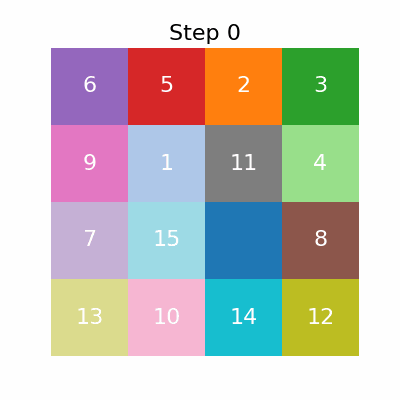

In [ ]:
dim = 4
moves = 20

# Generate a NxN solution grid in order from 0 to 15
goal_state: NDArray[np.int32] = generate_goal_state(dim)

# Generate a NxN grid of random numbers from 0 to 15
initial_state: NDArray[np.int32] = scramble_state(goal_state, moves)

print("Starting Grid:")
print(initial_state)
print()
print("Solution Grid:")
print(goal_state)
print("-------------------")

# Solve using Breadth First Search
bfs_path = BFS(initial_state, goal_state).solve()
if bfs_path:
    save_solution_gif(bfs_path)